<a href="https://colab.research.google.com/github/VinitVpANDEY/Neural-Network/blob/main/WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [ ]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# Build vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# Shuffle words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# Build the dataset
context_size = 8

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * context_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr[:4])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 25],
        [ 0,  0,  0,  0,  0,  0, 25, 21],
        [ 0,  0,  0,  0,  0, 25, 21,  8]])


In [ ]:
# Neural Network

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))  # C matrix

    def __call__(self, IX):
        self.out = self.weight[IX]       # emb = C[x] (embed the characters into vectors)
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):   # here n is number of characters you want to fuse (in our case n = 2)
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape   # ( number of examples , context_size(8) , embedding_size )
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:  # if 1st dim = 1 then instead of keeping it 3d vector squeeze along 1st dim and make it 2d
            x = x.squeeze(1)     # (A,1,B) => (A,B)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5   # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2: dim = 0
            elif x.ndim == 3: dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]



class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [ ]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
block_size = 2;
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size), Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(block_size), Linear(n_hidden*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(block_size), Linear(n_hidden*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

76579


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2937
  10000/ 200000: 2.3229
  20000/ 200000: 2.0107
  30000/ 200000: 2.3103
  40000/ 200000: 2.0145
  50000/ 200000: 2.3966
  60000/ 200000: 1.9609
  70000/ 200000: 1.8159
  80000/ 200000: 1.5147
  90000/ 200000: 1.7768
 100000/ 200000: 1.9602
 110000/ 200000: 2.0018
 120000/ 200000: 1.8077
 130000/ 200000: 2.2636
 140000/ 200000: 1.6641
 150000/ 200000: 1.9409
 160000/ 200000: 1.6543
 170000/ 200000: 2.0165
 180000/ 200000: 2.0214
 190000/ 200000: 1.8306


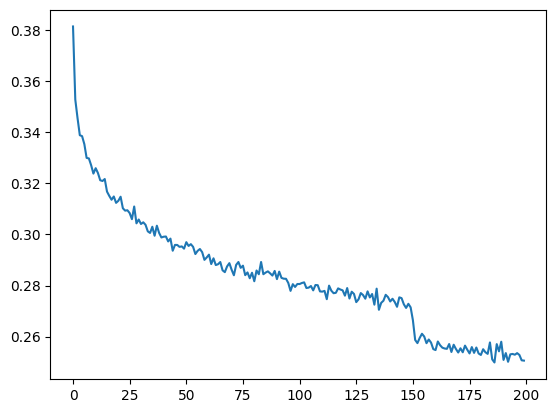

In [ ]:
torch.tensor(lossi).view(-1, 1000).shape             # torch.Size([200, 1000])
torch.tensor(lossi).view(-1, 1000).mean(1).shape     # torch.Size([200])
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# lossi is list of floats and we're going to stretch it out into rows of 1000
# consecutive elements so the shape of this now becomes 200 by 1000, and each row
# is one thousand consecutive elements in this list so that's very helpful because
# now we can do a mean along the rows and the shape of this will just be 200.

In [ ]:
# Eval Mode

# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7676700353622437
val 1.9915080070495605


In [ ]:
# Sample from model

for _ in range(20):
    out = []
    context = [0] * context_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break

    print(''.join(itos[i] for i in out))

kynger.
axtyn.
lazlee.
paxtin.
nyell.
macia.
maleah.
daelyn.
hanell.
xayane.
reberic.
mayana.
clarod.
indi.
dneythum.
roniz.
zellina.
alaysha.
kellan.
advit.
